In [107]:

import pandas as pd
import dotenv
import os
from src.regime.utils import (
    retest_from_latest_base_swing,
    find_all_retest_swing,
    add_peak_regime_data,
)
dotenv.load_dotenv()

True

Control Panel

In [108]:
# Pull price data from db for this ticker
symbol = 'SPY'
interval = '1h'

In [109]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol
neon_db_url = os.environ.get("NEON_DB_CONSTR")
# create query select left join where stock_data.stock_id equals select stock_id from stock where symbol = symbol
q = (
     "select {table}.*, stock.symbol, stock.is_relative "
     "from {table} "
     "left join stock on {table}.stock_id = stock.id "
     "where stock.symbol = '{symbol}' "
     "and stock.interval = '{interval}' "
     "{extra}"
).format

stock_data = pd.read_sql(q(table='stock_data', symbol=symbol, interval=interval, extra="order by stock_data.bar_number asc"), con=neon_db_url)
regime_data = pd.read_sql(q(table='regime', symbol=symbol, interval=interval, extra=""), con=neon_db_url)
peak_data = pd.read_sql(q(table='peak', symbol=symbol, interval=interval, extra=""), con=neon_db_url)


In [110]:

# plot stock_data close, lo3 as green up arrow, hi3 as red down arrow. rg, sma, and bo plotted on second y axis
def plot(_stock_data, title):
    style_map = {
        'close': '-', # line

        'lo3': 'g^', # green up arrow
        'dlo3': 'k^', # black up arrow (white for dark mode)

        'hi3': 'rv', # red down arrow
        'dhi3': 'kv', # black down arrow (white for dark mode)

        'lo2': 'g.', # green dot
        'dlo2': 'k.', # black dot (white for dark mode)

        'hi2': 'r.', # red dot
        'dhi2': 'm.', # magenta dot

        'fc': 'b--', # blue dashed line
        'sma': 'y--', # yellow dashed line
        'bo': 'k--', # black dashed line (white for dark mode)
        'tt': 'c--' # cyan dashed line
    }
    remove_keys = []
    for key, val in style_map.items():
        if key not in _stock_data.columns:
            remove_keys.append(key)
    for key in remove_keys:
        style_map.pop(key)
    secondary_y = ['fc', 'sma', 'bo', 'tt']
    try:
        _stock_data[
            style_map.keys()].plot(style=list(style_map.values()), secondary_y=secondary_y, figsize=(15, 10), title=title)
    except KeyError:
        pass


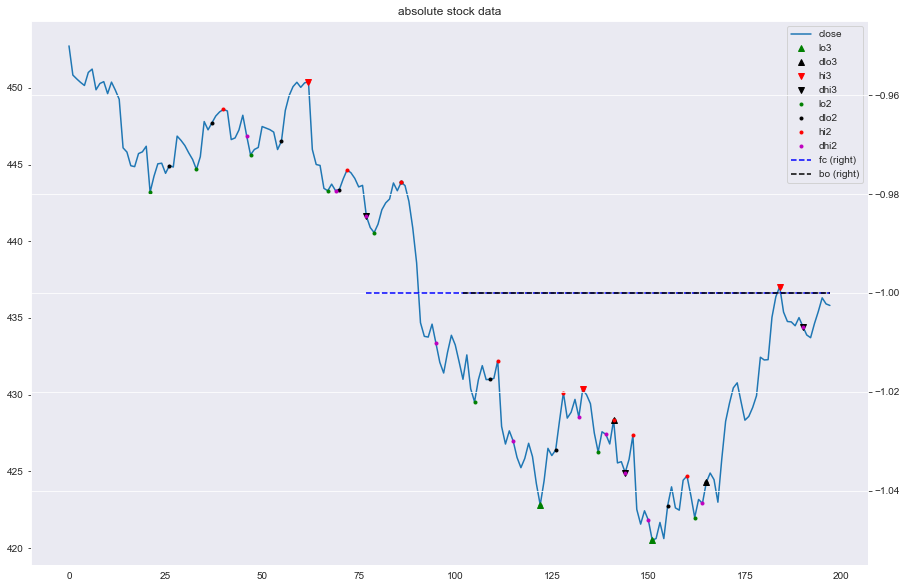

In [111]:

peak_data.lvl = peak_data.lvl.astype(int)
absolute_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == False].reset_index(drop=True),
    regime_data.loc[regime_data.is_relative == False].reset_index(drop=True),
    peak_data.loc[peak_data.is_relative == False].reset_index(drop=True)
)
last_peak = peak_data.loc[peak_data.lvl == 3]
last_peak_type = last_peak['type'].iloc[-1]
r_ = retest_from_latest_base_swing(
    peak_data,
    stock_data,
    last_peak_type,
    retest_swing_lvl=1,
    base_swing_lvl=3
)
plot(absolute_stock_data, 'absolute stock data')

In [112]:

relative_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == True].reset_index(drop=True),
    regime_data.loc[regime_data.is_relative == True].reset_index(drop=True),
    peak_data.loc[peak_data.is_relative == True].reset_index(drop=True)
)


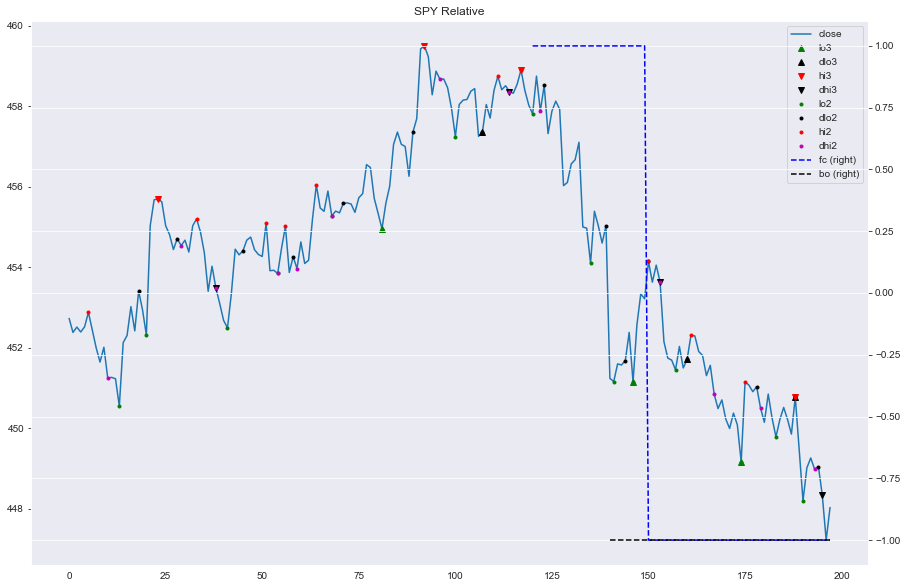

In [113]:
plot(relative_stock_data, f'{symbol} Relative')

In [114]:
import matplotlib.pyplot as plt
"""
calculate order data
- inputs: peak_row
- order_type (short/long) = peak_row['type']
- stop_loss = peak_row.st_px
- limit_price * order_type <= (peak_row.st_px * order_type) * 1.5 + (order_type *

target_price = en_px + ((en_px - stop_loss) * 1.5)
limit_entry <= (stop_loss * order_type) / (order_type - 0.02)
max_target_price = limit_entry + (limit_entry - stop_loss) * 1.5
if max_target_price < local_max, solve for limit_entry
limit_entry = (max_target_price - (stop_loss * order_type) * 1.5) / (order_type - 0.02)
"""
def entry_data_on_peak(_peak_data, entry_price, return_type):
    entry_data = return_type()
    entry_data['type'] = _peak_data['type']
    entry_data['stop_loss'] = _peak_data['st_px']
    entry_data['limit_entry'] = (entry_data["stop_loss"] * entry_data['type']) / (entry_data['type'] - 0.02)
    entry_data['limit_target_exit'] = entry_data["limit_entry"] + ((entry_data["limit_entry"] - entry_data["stop_loss"]) * 1.5)
    entry_data['peak_id'] = _peak_data.index
    return entry_data


def latest_entry_data_on_peak(_peak_table, entry_type, swing_lvl, return_type):
    filtered_peaks = _peak_table.loc[(_peak_table.lvl == swing_lvl) & (_peak_table['type'] == entry_type)]
    # sort by start
    selected_peak = filtered_peaks.sort_values(by=['start']).iloc[-1]

    return entry_data_on_peak(filtered_peaks.iloc[-1], return_type)

peak_filtered_entry = peak_data.loc[
    (peak_data.start > regime_data.iloc[-1].start) & 
    (peak_data.type == regime_data.iloc[-1].rg) &
    (peak_data.is_relative == False)
    
]
entries_lvl2 = entry_data_on_peak(
    peak_filtered_entry.loc[peak_filtered_entry.lvl == 2],
    pd.DataFrame)

entries_lvl3 = entry_data_on_peak(
    peak_filtered_entry.loc[peak_filtered_entry.lvl == 3],
    pd.DataFrame)

# d2, d2_peak = latest_entry_data_on_peak(peak_data, regime_data.rg.iloc[-1], 2)
# d3, d3_peak = latest_entry_data_on_peak(peak_data, regime_data.rg.iloc[-1], 3)
# plot horizontal lines for entry, stop loss, and target on close price


def plot_entry_data(_stock_data, _entry_data):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(_stock_data.close)
    ax.axhline(y=_entry_data['stop_loss'], color='r', linestyle='-')
    ax.axhline(y=_entry_data['limit_entry'], color='g', linestyle='-')
    ax.axhline(y=_entry_data['limit_target_exit'], color='b', linestyle='-')

plot_entry_data(absolute_stock_data, entries_lvl2.iloc[-1])

TypeError: entry_data_on_peak() missing 1 required positional argument: 'return_type'